In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
import optuna


warnings.simplefilter('ignore', FutureWarning)

In [2]:
!pip install xgboost
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [3]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

In [4]:
train_df = pd.read_csv('/kaggle/input/data-split/train_split/04/train_april.csv')
test_df = pd.read_csv('/kaggle/input/data-split/train_split/04/test_april.csv')

In [5]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

## Chuẩn hóa

In [6]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Chọn feature

In [7]:
top_features =  ['CAPE', 'KX', 'R500', 'R850', 'TCLW', 'TCW', 'U250', 'U850', 'V250', 'V850', 'B10B', 'B11B', 'B14B', 'I2B', 'I4B', 'IRB', 'WVB']

## Hàm bổ trợ

In [8]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight= neg / pos
print(f"scale_pos_weight= {scale_pos_weight:.3f}")

scale_pos_weight= 13.097


In [9]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [10]:
def train_and_evaluate_xgb(X_train, y_train, X_test, y_test, scale_pos_weight=None, top_features=None):
    model_xgb = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)

    if top_features is not None:
        X_train = X_train[top_features]
        X_test = X_test[top_features]
    
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    print_scores(y_test, y_pred)

In [11]:
def objective(trial, X_train_scaled, y_train, X_test_scaled, y_test, 
              use_smote=False, use_smoteenn=False, 
              scale_pos_weight=None, top_features=None):
    # Tối ưu hóa các tham số
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': scale_pos_weight if not (use_smote or use_smoteenn) else None,
        'random_state': 42,
        'verbosity': 0,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

     # Sử dụng top_features để chọn các đặc trưng quan trọng
    if top_features is not None:
        X_train_scaled = X_train_scaled[top_features]
        X_test_scaled = X_test_scaled[top_features]
        
    # Khởi tạo mô hình với tham số tối ưu
    model = xgb.XGBClassifier(**param)
    model.fit(X_train_scaled, y_train)
    
    # Dự đoán và tối ưu hóa threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    best_thresh = trial.suggest_float('threshold', 0.1, 0.9, step=0.05)
    y_pred = (y_probs >= best_thresh).astype(int)

    # Đánh giá mô hình với F1 score
    return f1_score(y_test, y_pred, pos_label=1)

In [12]:
def optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,
                       use_smote=False, use_smoteenn=False,
                       scale_pos_weight=None, top_features=None,
                       n_trials=50):
    # Tạo study và tối ưu hóa tham số
    study = optuna.create_study(direction='maximize')

    # Thay đổi lambda function để truyền đúng các đối số vào objective
    study.optimize(lambda trial: objective(trial, X_train_scaled, y_train, X_test_scaled, y_test,
                                           use_smote, use_smoteenn, scale_pos_weight, top_features),
                   n_trials=n_trials)

    # In kết quả của trial tốt nhất
    print("Best trial:")
    print(study.best_trial)
    print("Best hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")

    # Huấn luyện lại với tham số tốt nhất
    best_params = study.best_trial.params
    best_thresh = best_params.pop('threshold')  # Lấy ngưỡng tối ưu từ Optuna

    best_params.update({
        'scale_pos_weight': scale_pos_weight if not (use_smote or use_smoteenn) else None,
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    })
    
    best_model = xgb.XGBClassifier(**best_params)
    best_model.fit(X_train_scaled, y_train)

    # Dự đoán với threshold tối ưu
    y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_thresh = (y_probs >= best_thresh).astype(int)

    print(f"Best threshold: {best_thresh}")
    print_scores(y_test, y_pred_thresh)

# Không SMOTE

## Data

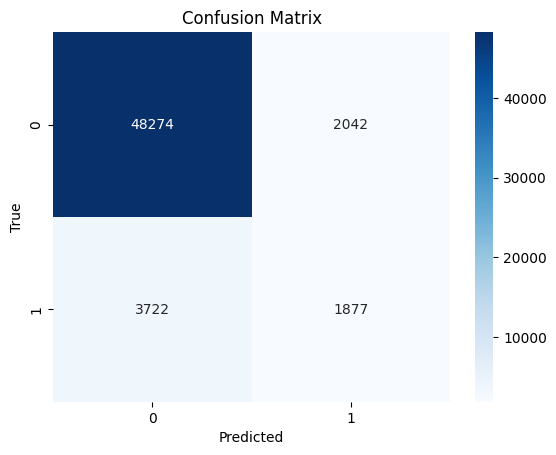

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     50316
           1       0.48      0.34      0.39      5599

    accuracy                           0.90     55915
   macro avg       0.70      0.65      0.67     55915
weighted avg       0.88      0.90      0.89     55915



In [13]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test)

## Data tune

[I 2025-05-05 15:48:39,739] A new study created in memory with name: no-name-41758b53-257f-4e0a-885a-75a96830a91f
[I 2025-05-05 15:48:48,682] Trial 0 finished with value: 0.1874221668742217 and parameters: {'n_estimators': 469, 'learning_rate': 0.1484429284466471, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6554104357592985, 'colsample_bytree': 0.7860217762894773, 'gamma': 1.756364502233464, 'threshold': 0.8}. Best is trial 0 with value: 0.1874221668742217.
[I 2025-05-05 15:48:57,290] Trial 1 finished with value: 0.37597850216146744 and parameters: {'n_estimators': 367, 'learning_rate': 0.11328759419191282, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6303627927053008, 'colsample_bytree': 0.958972923689406, 'gamma': 0.903071943247637, 'threshold': 0.55}. Best is trial 1 with value: 0.37597850216146744.
[I 2025-05-05 15:49:06,015] Trial 2 finished with value: 0.4338349766476388 and parameters: {'n_estimators': 237, 'learning_rate': 0.24810970213200134, 'max_depth': 6,

Best trial:
FrozenTrial(number=14, state=1, values=[0.4551514273293725], datetime_start=datetime.datetime(2025, 5, 5, 15, 50, 24, 896298), datetime_complete=datetime.datetime(2025, 5, 5, 15, 50, 32, 448377), params={'n_estimators': 415, 'learning_rate': 0.19359427375011456, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.8953697964498782, 'colsample_bytree': 0.6550925079869592, 'gamma': 2.1486140396919593, 'threshold': 0.25}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.

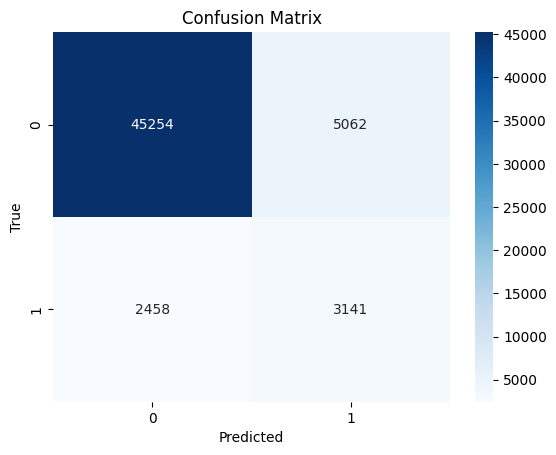

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     50316
           1       0.38      0.56      0.46      5599

    accuracy                           0.87     55915
   macro avg       0.67      0.73      0.69     55915
weighted avg       0.89      0.87      0.88     55915



In [14]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test)

## Data + feature

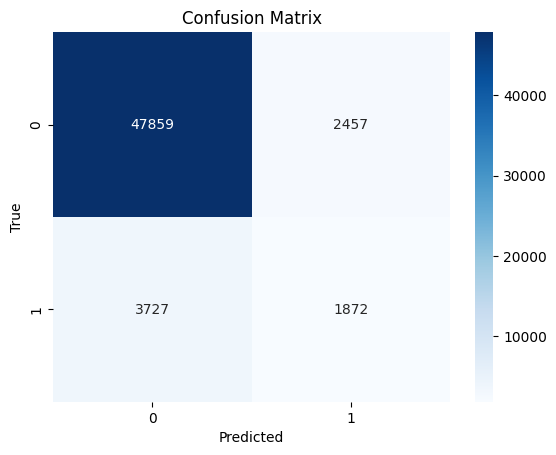

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     50316
           1       0.43      0.33      0.38      5599

    accuracy                           0.89     55915
   macro avg       0.68      0.64      0.66     55915
weighted avg       0.88      0.89      0.88     55915



In [15]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + Feature + Tune

[I 2025-05-05 15:56:09,363] A new study created in memory with name: no-name-45acb64e-a7aa-405b-869a-1c4759d57c44
[I 2025-05-05 15:56:15,109] Trial 0 finished with value: 0.3933190657858007 and parameters: {'n_estimators': 438, 'learning_rate': 0.10790723970994405, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.585046314992633, 'colsample_bytree': 0.6917277982526016, 'gamma': 3.372015574059541, 'threshold': 0.1}. Best is trial 0 with value: 0.3933190657858007.
[I 2025-05-05 15:56:19,590] Trial 1 finished with value: 0.4034128561961564 and parameters: {'n_estimators': 475, 'learning_rate': 0.2798319721995569, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.6170864150705322, 'colsample_bytree': 0.5338494560690354, 'gamma': 3.623547865670263, 'threshold': 0.30000000000000004}. Best is trial 1 with value: 0.4034128561961564.
[I 2025-05-05 15:56:21,591] Trial 2 finished with value: 0.3594715533773706 and parameters: {'n_estimators': 147, 'learning_rate': 0.0539558482023727, 'ma

Best trial:
FrozenTrial(number=18, state=1, values=[0.4293932338035886], datetime_start=datetime.datetime(2025, 5, 5, 15, 57, 21, 418653), datetime_complete=datetime.datetime(2025, 5, 5, 15, 57, 26, 706321), params={'n_estimators': 430, 'learning_rate': 0.1523748015858789, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7700660163855216, 'colsample_bytree': 0.8609179509549744, 'gamma': 0.06143735590984001, 'threshold': 0.25}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0

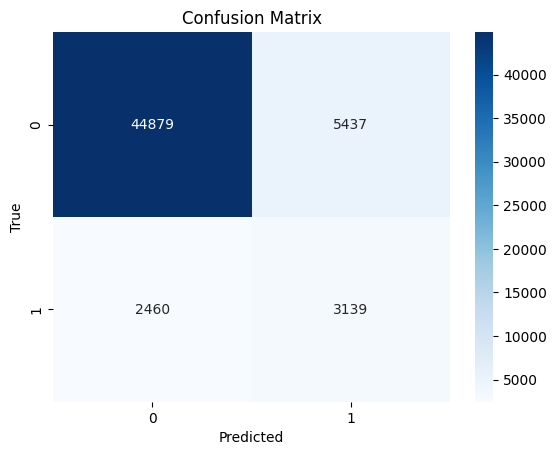

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     50316
           1       0.37      0.56      0.44      5599

    accuracy                           0.86     55915
   macro avg       0.66      0.73      0.68     55915
weighted avg       0.89      0.86      0.87     55915



In [16]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + scale_pos_weight

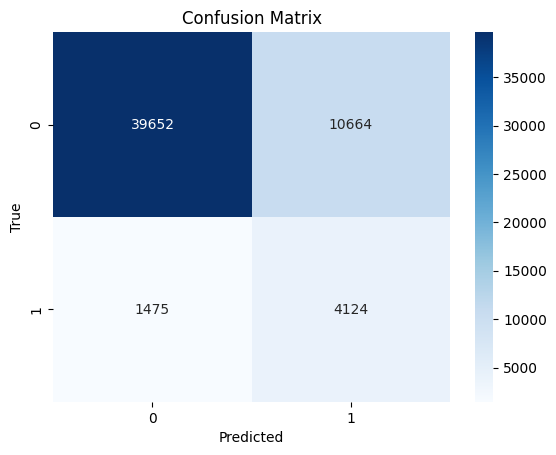

              precision    recall  f1-score   support

           0       0.96      0.79      0.87     50316
           1       0.28      0.74      0.40      5599

    accuracy                           0.78     55915
   macro avg       0.62      0.76      0.64     55915
weighted avg       0.90      0.78      0.82     55915



In [17]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test, scale_pos_weight=scale_pos_weight)

## Data + scale_pos_weight + Tune

[I 2025-05-05 16:00:14,993] A new study created in memory with name: no-name-33fe3447-94b2-45e2-81e6-094c2ae85951
[I 2025-05-05 16:00:17,287] Trial 0 finished with value: 0.27849657964182317 and parameters: {'n_estimators': 153, 'learning_rate': 0.10375243241878071, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.8826973632514552, 'colsample_bytree': 0.8105981586233524, 'gamma': 4.9678361644285856, 'threshold': 0.25}. Best is trial 0 with value: 0.27849657964182317.
[I 2025-05-05 16:00:30,137] Trial 1 finished with value: 0.3219087793303454 and parameters: {'n_estimators': 416, 'learning_rate': 0.2131057548738107, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8539208265166169, 'colsample_bytree': 0.8956574632799261, 'gamma': 3.9281871978880787, 'threshold': 0.9}. Best is trial 1 with value: 0.3219087793303454.
[I 2025-05-05 16:00:34,712] Trial 2 finished with value: 0.32461216449150454 and parameters: {'n_estimators': 283, 'learning_rate': 0.03124927949090372, 'max_depth'

Best trial:
FrozenTrial(number=33, state=1, values=[0.4527984289521672], datetime_start=datetime.datetime(2025, 5, 5, 16, 4, 31, 966618), datetime_complete=datetime.datetime(2025, 5, 5, 16, 4, 38, 947929), params={'n_estimators': 444, 'learning_rate': 0.215340813833416, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.871414565224175, 'colsample_bytree': 0.5389059659033845, 'gamma': 3.3355707356920226, 'threshold': 0.65}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, st

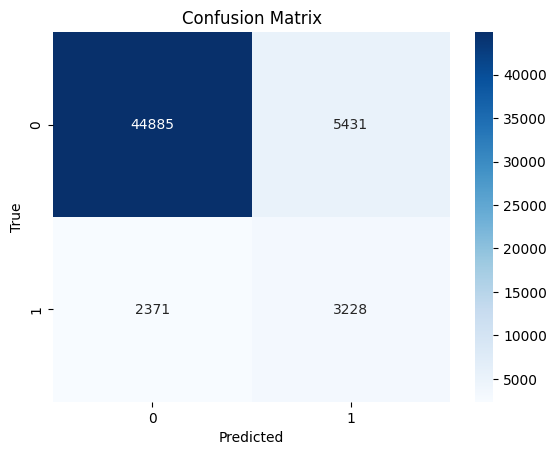

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     50316
           1       0.37      0.58      0.45      5599

    accuracy                           0.86     55915
   macro avg       0.66      0.73      0.69     55915
weighted avg       0.89      0.86      0.87     55915



In [18]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,scale_pos_weight=scale_pos_weight)

## Data + scale_pos_weight + feature 

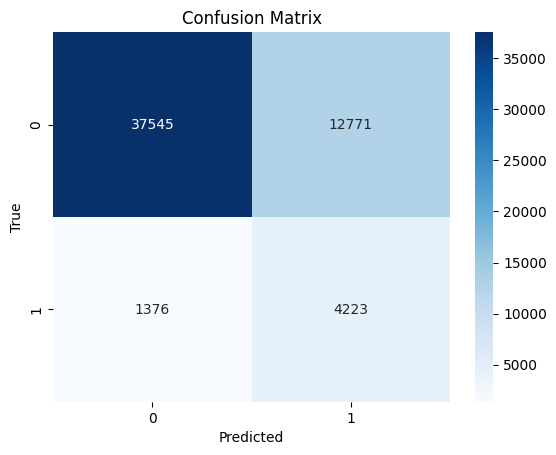

              precision    recall  f1-score   support

           0       0.96      0.75      0.84     50316
           1       0.25      0.75      0.37      5599

    accuracy                           0.75     55915
   macro avg       0.61      0.75      0.61     55915
weighted avg       0.89      0.75      0.79     55915



In [19]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test, scale_pos_weight=scale_pos_weight, top_features=top_features)

## Data + scale_pos_weight + feature + tune

[I 2025-05-05 16:06:43,760] A new study created in memory with name: no-name-1e49b13f-6927-43a7-9834-1e185d0b6122
[I 2025-05-05 16:06:47,754] Trial 0 finished with value: 0.41896486588590853 and parameters: {'n_estimators': 382, 'learning_rate': 0.20250744892598949, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8475678783975958, 'colsample_bytree': 0.572237188241417, 'gamma': 3.1403399902328704, 'threshold': 0.75}. Best is trial 0 with value: 0.41896486588590853.
[I 2025-05-05 16:06:51,961] Trial 1 finished with value: 0.34244215504137815 and parameters: {'n_estimators': 255, 'learning_rate': 0.2021808980757739, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.8019874303708189, 'colsample_bytree': 0.8092669666609006, 'gamma': 3.459005831948803, 'threshold': 0.4}. Best is trial 0 with value: 0.41896486588590853.
[I 2025-05-05 16:06:55,051] Trial 2 finished with value: 0.3606652625462996 and parameters: {'n_estimators': 309, 'learning_rate': 0.03490871495187212, 'max_depth':

Best trial:
FrozenTrial(number=40, state=1, values=[0.4259589652096343], datetime_start=datetime.datetime(2025, 5, 5, 16, 9, 59, 238025), datetime_complete=datetime.datetime(2025, 5, 5, 16, 10, 8, 9421), params={'n_estimators': 321, 'learning_rate': 0.21007015650777883, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.6913605324591409, 'colsample_bytree': 0.5021636184061029, 'gamma': 3.8463321719079264, 'threshold': 0.55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, s

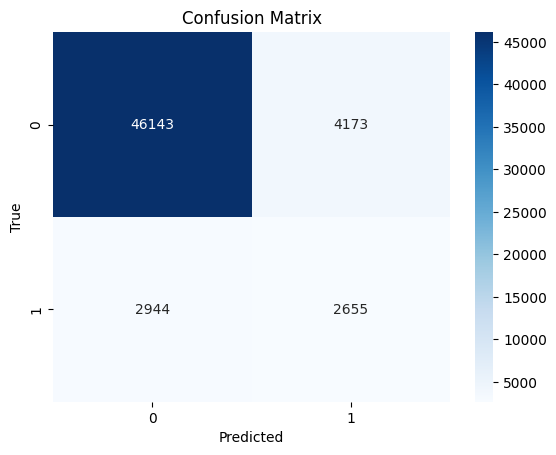

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     50316
           1       0.39      0.47      0.43      5599

    accuracy                           0.87     55915
   macro avg       0.66      0.70      0.68     55915
weighted avg       0.88      0.87      0.88     55915



In [20]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,scale_pos_weight=scale_pos_weight, top_features = top_features)

# SMOTE

In [21]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE 

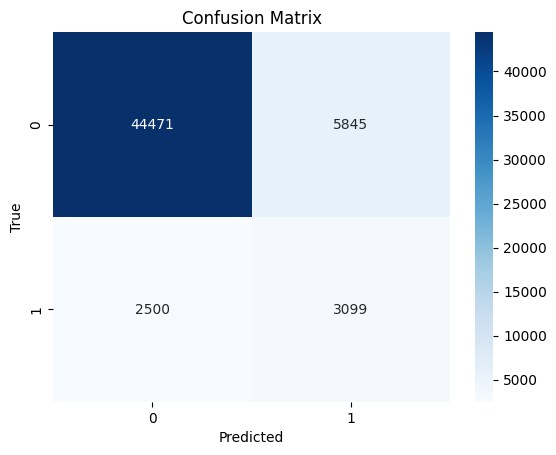

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     50316
           1       0.35      0.55      0.43      5599

    accuracy                           0.85     55915
   macro avg       0.65      0.72      0.67     55915
weighted avg       0.89      0.85      0.87     55915



In [22]:
train_and_evaluate_xgb(X_train_scaled, y_sm, X_test_scaled, y_test)

## Data SMOTE + Tune

[I 2025-05-05 16:11:22,677] A new study created in memory with name: no-name-02aa01b1-9fd8-427e-af6e-507b53c525e3
[I 2025-05-05 16:11:30,514] Trial 0 finished with value: 0.4280319748908832 and parameters: {'n_estimators': 279, 'learning_rate': 0.0969688017950865, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.530622248442131, 'colsample_bytree': 0.7360789495283748, 'gamma': 0.04534958424688207, 'threshold': 0.4}. Best is trial 0 with value: 0.4280319748908832.
[I 2025-05-05 16:11:41,231] Trial 1 finished with value: 0.44546514019332284 and parameters: {'n_estimators': 304, 'learning_rate': 0.18073027981351963, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.7313740007878378, 'colsample_bytree': 0.5818872605827327, 'gamma': 1.8002354200215671, 'threshold': 0.45000000000000007}. Best is trial 1 with value: 0.44546514019332284.
[I 2025-05-05 16:11:45,745] Trial 2 finished with value: 0.36685477650115705 and parameters: {'n_estimators': 107, 'learning_rate': 0.250732053906566

Best trial:
FrozenTrial(number=14, state=1, values=[0.454639709694142], datetime_start=datetime.datetime(2025, 5, 5, 16, 14, 10, 318768), datetime_complete=datetime.datetime(2025, 5, 5, 16, 14, 16, 803659), params={'n_estimators': 214, 'learning_rate': 0.13646235896977155, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8019901304756193, 'colsample_bytree': 0.9207202843679854, 'gamma': 0.6205251472293805, 'threshold': 0.55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0

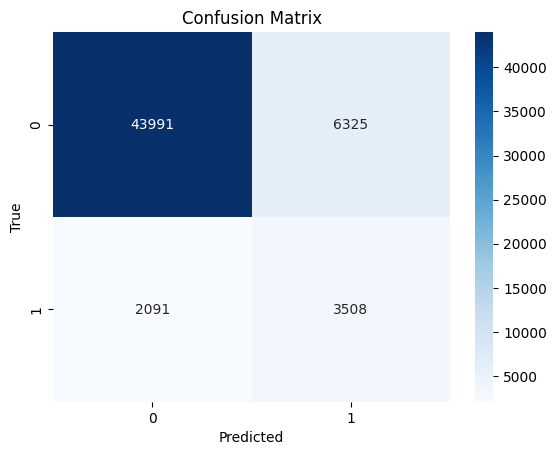

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     50316
           1       0.36      0.63      0.45      5599

    accuracy                           0.85     55915
   macro avg       0.66      0.75      0.68     55915
weighted avg       0.89      0.85      0.87     55915



In [23]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, use_smote=True)

## Data SMOTE + Feature

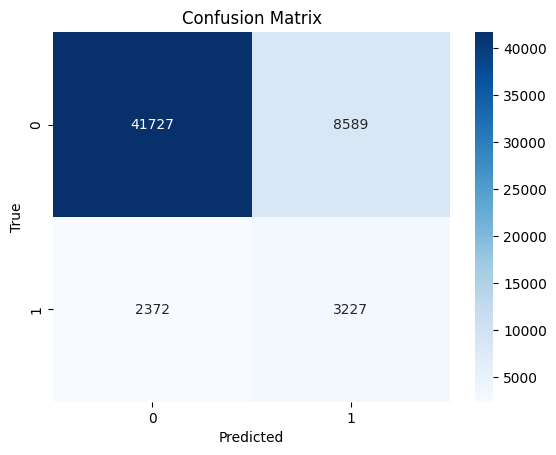

              precision    recall  f1-score   support

           0       0.95      0.83      0.88     50316
           1       0.27      0.58      0.37      5599

    accuracy                           0.80     55915
   macro avg       0.61      0.70      0.63     55915
weighted avg       0.88      0.80      0.83     55915



In [24]:
train_and_evaluate_xgb(X_train_scaled, y_sm, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE + Feature + Tune

[I 2025-05-05 16:19:52,440] A new study created in memory with name: no-name-121f4975-818d-4d5b-9dc8-54d84f22d2df
[I 2025-05-05 16:20:03,999] Trial 0 finished with value: 0.32810671659255786 and parameters: {'n_estimators': 337, 'learning_rate': 0.20915578821191066, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.6707023075946071, 'colsample_bytree': 0.5544394792883156, 'gamma': 1.3503687848886425, 'threshold': 0.35}. Best is trial 0 with value: 0.32810671659255786.
[I 2025-05-05 16:20:12,453] Trial 1 finished with value: 0.2724291155311045 and parameters: {'n_estimators': 239, 'learning_rate': 0.10426952975685752, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9152191766049211, 'colsample_bytree': 0.5195491263542518, 'gamma': 1.8430969580843537, 'threshold': 0.1}. Best is trial 0 with value: 0.32810671659255786.
[I 2025-05-05 16:20:23,235] Trial 2 finished with value: 0.29568802611235184 and parameters: {'n_estimators': 272, 'learning_rate': 0.21835672221368033, 'max_dept

Best trial:
FrozenTrial(number=46, state=1, values=[0.43295716539254947], datetime_start=datetime.datetime(2025, 5, 5, 16, 26, 36, 537287), datetime_complete=datetime.datetime(2025, 5, 5, 16, 26, 42, 440476), params={'n_estimators': 307, 'learning_rate': 0.025934070144608284, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.5297161492529753, 'colsample_bytree': 0.535844755604348, 'gamma': 0.5442722086281011, 'threshold': 0.75}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0

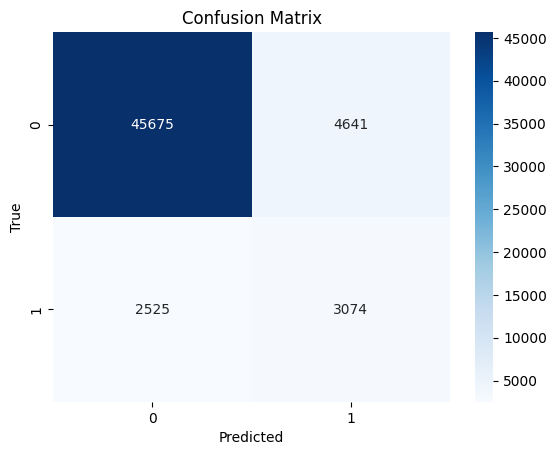

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     50316
           1       0.40      0.55      0.46      5599

    accuracy                           0.87     55915
   macro avg       0.67      0.73      0.69     55915
weighted avg       0.89      0.87      0.88     55915



In [25]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, top_features=top_features, use_smote = True)

# SMOTE ENN

In [26]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE ENN 

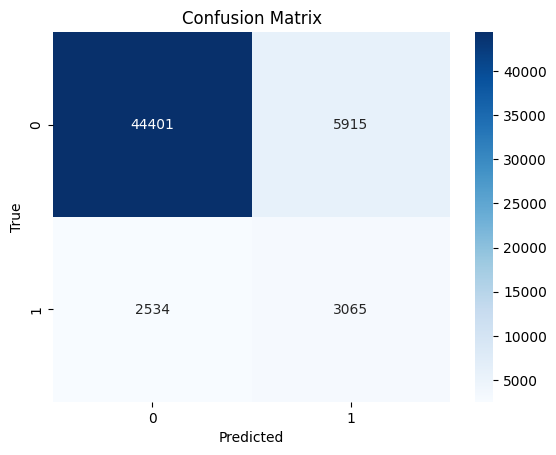

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     50316
           1       0.34      0.55      0.42      5599

    accuracy                           0.85     55915
   macro avg       0.64      0.71      0.67     55915
weighted avg       0.89      0.85      0.86     55915



In [27]:
train_and_evaluate_xgb(X_train_scaled, y_smenn, X_test_scaled, y_test)

## Data SMOTE ENN + Tune

[I 2025-05-05 16:35:58,018] A new study created in memory with name: no-name-ed61fad8-f9ac-4374-aaca-0111a11207b7
[I 2025-05-05 16:36:05,810] Trial 0 finished with value: 0.29357545742192875 and parameters: {'n_estimators': 337, 'learning_rate': 0.16714252218583883, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7524978480028108, 'colsample_bytree': 0.9339368713434585, 'gamma': 2.307579088237745, 'threshold': 0.9}. Best is trial 0 with value: 0.29357545742192875.
[I 2025-05-05 16:36:23,593] Trial 1 finished with value: 0.44775878748790715 and parameters: {'n_estimators': 413, 'learning_rate': 0.19847018088736976, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.7128216335694408, 'colsample_bytree': 0.6464137972129701, 'gamma': 0.3904443944882713, 'threshold': 0.5}. Best is trial 1 with value: 0.44775878748790715.
[I 2025-05-05 16:36:36,232] Trial 2 finished with value: 0.4110313562523612 and parameters: {'n_estimators': 486, 'learning_rate': 0.1323467618672092, 'max_depth'

Best trial:
FrozenTrial(number=39, state=1, values=[0.45574250182882226], datetime_start=datetime.datetime(2025, 5, 5, 16, 43, 1, 177822), datetime_complete=datetime.datetime(2025, 5, 5, 16, 43, 10, 556838), params={'n_estimators': 422, 'learning_rate': 0.052790136729750636, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6402870584909081, 'colsample_bytree': 0.5780991039917405, 'gamma': 1.6797099789445893, 'threshold': 0.7000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, l

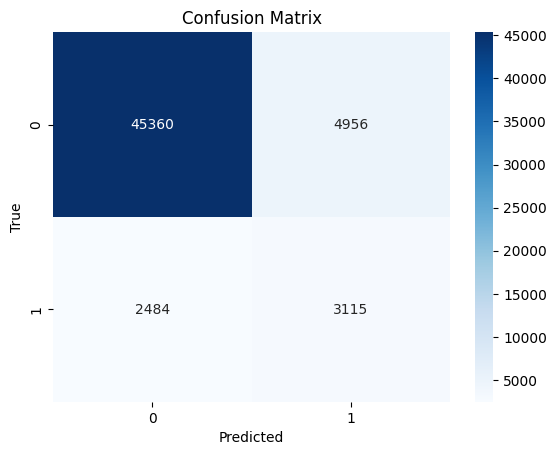

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     50316
           1       0.39      0.56      0.46      5599

    accuracy                           0.87     55915
   macro avg       0.67      0.73      0.69     55915
weighted avg       0.89      0.87      0.88     55915



In [28]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, use_smoteenn = True)

## Data SMOTE ENN + Feature

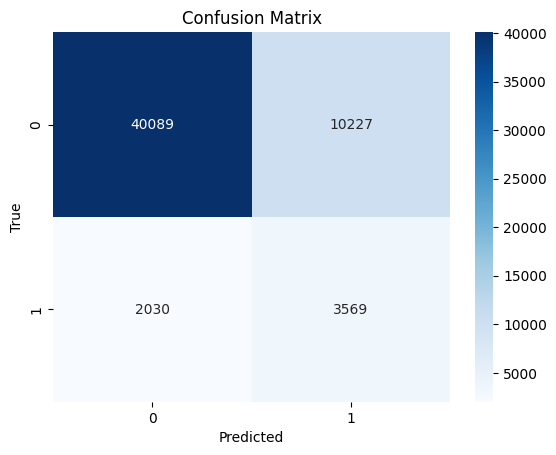

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     50316
           1       0.26      0.64      0.37      5599

    accuracy                           0.78     55915
   macro avg       0.61      0.72      0.62     55915
weighted avg       0.88      0.78      0.82     55915



In [29]:
train_and_evaluate_xgb(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE ENN + Feature + Tune

[I 2025-05-05 16:44:57,930] A new study created in memory with name: no-name-ca008065-9840-4eb5-929e-319e04df7cda
[I 2025-05-05 16:45:12,111] Trial 0 finished with value: 0.2863431214130496 and parameters: {'n_estimators': 430, 'learning_rate': 0.05645224017721441, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.6929217608176301, 'colsample_bytree': 0.9740713972433476, 'gamma': 4.968599953024978, 'threshold': 0.1}. Best is trial 0 with value: 0.2863431214130496.
[I 2025-05-05 16:45:20,953] Trial 1 finished with value: 0.4127431632365379 and parameters: {'n_estimators': 464, 'learning_rate': 0.035738359485336255, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.6642537332756508, 'colsample_bytree': 0.50188203868699, 'gamma': 0.26279652473884196, 'threshold': 0.75}. Best is trial 1 with value: 0.4127431632365379.
[I 2025-05-05 16:45:31,003] Trial 2 finished with value: 0.35820145692037175 and parameters: {'n_estimators': 404, 'learning_rate': 0.2928991925794493, 'max_depth': 8

Best trial:
FrozenTrial(number=43, state=1, values=[0.4212260667007557], datetime_start=datetime.datetime(2025, 5, 5, 16, 50, 9, 231093), datetime_complete=datetime.datetime(2025, 5, 5, 16, 50, 18, 371027), params={'n_estimators': 457, 'learning_rate': 0.02173454181556246, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7150623249294048, 'colsample_bytree': 0.8335828018987541, 'gamma': 4.766996355938096, 'threshold': 0.7000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=F

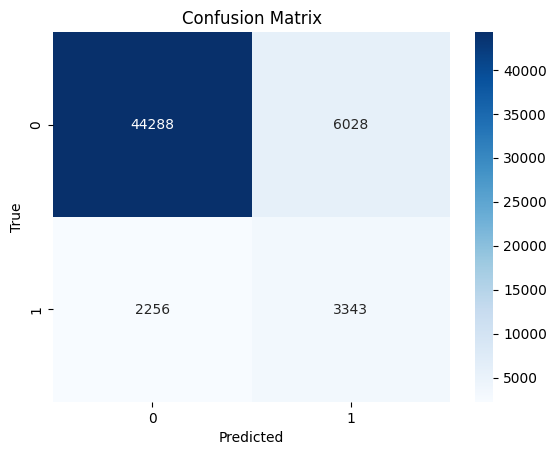

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     50316
           1       0.36      0.60      0.45      5599

    accuracy                           0.85     55915
   macro avg       0.65      0.74      0.68     55915
weighted avg       0.89      0.85      0.87     55915



In [30]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features=top_features,  use_smoteenn = True)